In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

CLAUDE_MODEL = "claude-sonnet-4-20250514"
GPT_MODEL = "gpt-4.1-mini-2025-04-14"

In [49]:
def passed_attention(participant_id):
    try:
        df = pd.read_csv("../data/surveys/Survey Builder Data - " + participant_id + ".csv")
    except:
        df = pd.read_csv("../data/surveys/" + participant_id + ".csv")
    results = pd.read_csv("../data/survey_responses/"+participant_id+".csv")
    results = results.transpose().reset_index()
    results = results.loc[2:].reset_index(drop=True)
    results = results[~results[0].isna()]
    df["response"] = results[0].to_list()
    df = df.loc[5:].reset_index(drop=True)
    
    passed_aita = df.loc[df["prompt_id"]=="aita-attention", "response"].to_list()[2].startswith("Very dissimilar")
    passed_politics = df.loc[df["prompt_id"]=="politics-attention", "response"].to_list()[1].startswith("Very dissimilar")
    return passed_aita and passed_politics



In [50]:
def get_table_for_regression(participant_id):
    try:
        df = pd.read_csv("../data/surveys/Survey Builder Data - " + participant_id + ".csv")
    except:
        df = pd.read_csv("../data/surveys/" + participant_id + ".csv")
    results = pd.read_csv("../data/survey_responses/"+participant_id+".csv")
    results = results.transpose().reset_index()
    results = results.loc[2:]
    results = results[~results[0].isna()].reset_index(drop=True)
    df["response"] = results[0].to_list()
    df = df.loc[5:].reset_index(drop=True)
    df["participant"] = participant_id
    df = df[["participant", "prompt_id", "model", "is_zero_shot", "response"]]
    df = df[df["prompt_id"]!="politics-attention"]
    df = df[df["prompt_id"]!="aita-attention"]
    df = df[df["model"].notna()]
    mapping = {
        'Very similar to the advice I would give': 4,
        'Somewhat similar to the advice I would give': 3,
        'Somewhat dissimilar to the advice I would give': 2,
        'Very dissimilar to the advice I would give': 1,
        'Very similar to my perspective': 4,
        'Somewhat similar to my perspective': 3,
        'Somewhat dissimilar to my perspective': 2,
        'Very dissimilar to my perspective': 1,
        'Very similar to my political views': 4,
        'Somewhat similar to my political views': 3,
        'Somewhat dissimilar to my political views': 2,
        'Very dissimilar to my political views': 1,
        'Very accurate': 5,
        'Somewhat accurate': 4,
        "Response didn't infer any of my views": 3,
        'Somewhat inaccurate': 2,
        'Very inaccurate': 1,
        "Response didn't infer my personality": 3,
    }

    df['mimesis'] = df['response'].map(mapping)
    df["task"] = df["prompt_id"].str.split("-").str[0]
    understanding = df[df["prompt_id"].isin(["infer-aita", "infer-politics"])].copy()
    understanding["understanding"] = understanding["mimesis"]
    understanding["task"] = understanding["prompt_id"].str.replace("infer-", "")
    understanding = understanding[["participant", "task", "model", "understanding"]]
    df = df[df["task"]!="infer"]
    df = df.merge(understanding, on=["participant", "task", "model"], how="left")
    df["context"] = 1-df["is_zero_shot"].astype(int)
    
    participants = pd.read_csv("../data/participants.csv")
    df = df.merge(participants[["user_id", "gender", "political_lean"]], left_on="participant", right_on="user_id", how="left")
    
    df = df[["model", "task", "participant", "prompt_id", "mimesis", "context", "gender", "political_lean", "understanding"]]
    return df

In [70]:
participants = pd.read_csv("../data/participants.csv")

results = []
for p in participants["user_id"].unique():
    if os.path.exists(f"../data/survey_responses/{p}.csv"):
        if passed_attention(p):
            results.append(get_table_for_regression(p))
        else:
            print(p)
            
df = pd.concat(results)

79dd0ab5da
0d61ff7fca
7988d8270a
21b0f45ecb
6bd0c96a21
e0b764637e


In [52]:
df.to_csv("../data/survey_results.csv", index=False)

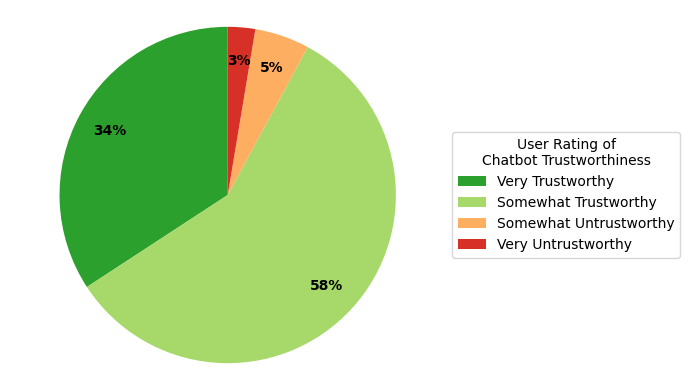

In [90]:
def get_trustworthy(participant_id):
    try:
        df = pd.read_csv("../data/surveys/Survey Builder Data - " + participant_id + ".csv")
    except:
        df = pd.read_csv("../data/surveys/" + participant_id + ".csv")
    results = pd.read_csv("../data/survey_responses/"+participant_id+".csv")
    results = results.transpose().reset_index()
    trustworthy = results.loc[5, 0]
    return trustworthy


participants = pd.read_csv("../data/participants.csv")

trustworthy = []
for p in participants["user_id"].unique():
    if os.path.exists(f"../data/survey_responses/{p}.csv"):
        if passed_attention(p):
            trustworthy.append(get_trustworthy(p))

# Count frequencies
counts = Counter(trustworthy)
labels = list(counts.keys())
sizes = list(counts.values())

# Define ordered categories and corresponding gradient colors
category_order = [
    "Very trustworthy",
    "Somewhat trustworthy",
    "Somewhat untrustworthy",
    "Very untrustworthy"
]

category_colors = {
    "Very trustworthy": "#2ca02c",   # strong green
    "Somewhat trustworthy": "#a6d96a", # lighter green/yellowish
    "Somewhat untrustworthy": "#fdae61", # orange
    "Very untrustworthy": "#d73027"  # strong red
}

# Match colors to the labels (keeps correct order even if some categories missing)
colors = [category_colors[label] for label in labels]

# Custom autopct function: show % only if >= 5%
def autopct_func(pct):
    return ('%1.f%%' % pct)

# --- Control figure size here ---
plt.figure(figsize=(7, 4))   # wider to fit legend

# Pie chart
wedges, texts, autotexts = plt.pie(
    sizes,
    colors=colors,
    autopct=autopct_func,
    startangle=90,
    pctdistance=0.8   # move % closer to the edge (default is 0.6)
)

for autotext in autotexts:
    autotext.set_fontweight("bold")


legend_labels = [label.title() for label in labels]

# Legend outside the pie on the right
plt.legend(
    wedges, legend_labels,
    title="        User Rating of\nChatbot Trustworthiness",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.axis('equal')
plt.tight_layout()
plt.savefig("figures/trustworthiness.jpg", dpi=300, bbox_inches="tight")
plt.show()



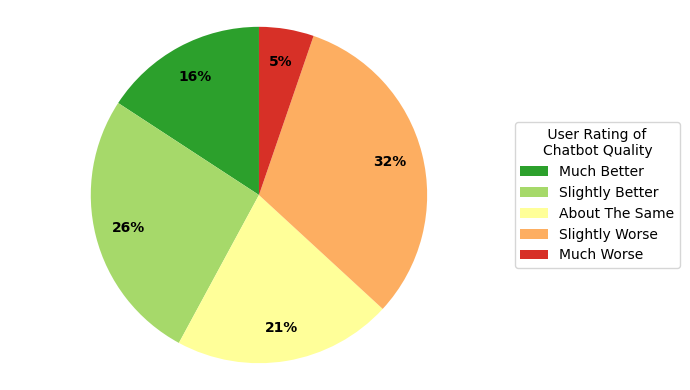

In [100]:
def get_quality(participant_id):
    try:
        df = pd.read_csv("../data/surveys/Survey Builder Data - " + participant_id + ".csv")
    except:
        df = pd.read_csv("../data/surveys/" + participant_id + ".csv")
    results = pd.read_csv("../data/survey_responses/"+participant_id+".csv")
    results = results.transpose().reset_index()
    quality = results.loc[6, 0]
    return quality


participants = pd.read_csv("../data/participants.csv")

quality = []
for p in participants["user_id"].unique():
    if os.path.exists(f"../data/survey_responses/{p}.csv"):
        if passed_attention(p):
            quality.append(get_quality(p).replace(" than other LLMs", "").replace(" as other LLMs", ""))

# Count frequencies
counts = Counter(quality)

category_order = [
    "Much better",
    "Slightly better",
    "About the same",
    "Slightly worse",
    "Much worse"
]

category_colors = {
    "Much better": "#2ca02c",      # strong green
    "Slightly better": "#a6d96a",  # lighter green/yellowish
    "About the same": "#ffff99",   # yellow
    "Slightly worse": "#fdae61",   # orange
    "Much worse": "#d73027"        # strong red
}

# Ensure order follows Likert scale
labels = [cat for cat in category_order if cat in counts]
sizes = [counts[cat] for cat in labels]

# Match colors to the labels (keeps correct order even if some categories missing)
colors = [category_colors[label] for label in labels]

# Custom autopct function: show % only if >= 5%
def autopct_func(pct):
    return ('%1.f%%' % pct)

# --- Control figure size here ---
plt.figure(figsize=(7, 4))   # wider to fit legend

# Pie chart
wedges, texts, autotexts = plt.pie(
    sizes,
    colors=colors,
    autopct=autopct_func,
    startangle=90,
    pctdistance=0.8   # move % closer to the edge (default is 0.6)
)

for autotext in autotexts:
    autotext.set_fontweight("bold")


legend_labels = [label.title() for label in labels]

# Legend outside the pie on the right
plt.legend(
    wedges, legend_labels,
    title=" User Rating of\nChatbot Quality",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.axis('equal')
plt.tight_layout()
plt.savefig("figures/quality.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [121]:
def get_user_verdicts(participant_id):
    try:
        df = pd.read_csv("../data/surveys/Survey Builder Data - " + participant_id + ".csv")
    except:
        df = pd.read_csv("../data/surveys/" + participant_id + ".csv")
    results = pd.read_csv("../data/survey_responses/"+participant_id+".csv")
    results = results.transpose().reset_index()
    results = results.loc[2:]
    results = results[~results[0].isna()].reset_index(drop=True)
    df["response"] = results[0].to_list()
    df = df.loc[5:].reset_index(drop=True)
    df = df[df["Question"]=="Do you think the narrator of the scenario was in the wrong?"]
    df["user_id"] = participant_id
    df["user_says_not_wrong"] = df["response"].str.startswith("No").astype(int)
    return df[["user_id", "prompt_id", "user_says_not_wrong"]]

participants = pd.read_csv("../data/participants.csv")

results = []
for p in participants["user_id"].unique():
    if os.path.exists(f"../data/survey_responses/{p}.csv"):
        if passed_attention(p):
            results.append(get_user_verdicts(p))
results = pd.concat(results)
results.to_csv("../data/user_verdicts.csv", index=False)

In [136]:
def get_topics(participant_id):
    try:
        df = pd.read_csv("../data/surveys/Survey Builder Data - " + participant_id + ".csv")
    except:
        df = pd.read_csv("../data/surveys/" + participant_id + ".csv")
    results = pd.read_csv("../data/survey_responses/" + participant_id + ".csv")
    results = results.transpose().reset_index()
    topics = results.loc[4, 0].split(" | ")
    return [t.strip() for t in topics]  # strip whitespace

participants = pd.read_csv("../data/participants.csv")

# master topic list
topics = [
    "Factual information (like using a search engine)",
    "Personal or social advice",
    "Professional or work-related writing (such as emails or resumes)",
    "Recommendations for hobbies or leisure activities",
    "Coding assistance or technical tasks",
    "Understanding news or political topics"
]

labels = ["factual_info", "personal_advice", "writing", "recommendations", "coding", "news_or_politics"]

rows = []
for p in participants["user_id"].unique():
    if os.path.exists(f"../data/survey_responses/{p}.csv"):
        if passed_attention(p):
            user_topics = get_topics(p)
            row = {"user_id": p}
            for t, lbl in zip(topics, labels):
                row[lbl] = 1 if t in user_topics else 0
            rows.append(row)

df_user_topics = pd.DataFrame(rows)
df_user_topics.to_csv("../data/user_topics.csv", index=False)